In [1]:
import math
from collections import defaultdict

import networkx as nx
import pandas as pd

articles_file_path = "data/wikispeedia/wikispeedia_paths-and-graph/articles.tsv"
paths_file_path = "data/wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv"
links_file_path = "data/wikispeedia/wikispeedia_paths-and-graph/links.tsv"


this is an attempt at reimplementing the semantic distance between wikipeedia articles presented in [West, Pineau, Precup ; Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts](http://infolab.stanford.edu/~west1/pubs/West-Pineau-Precup_IJCAI-09.pdf)

## Implementation of the distance

In [2]:
# Read articles
tsv_content = ""
with open(articles_file_path, "r") as f:
    tsv_content = f.read()

lines = tsv_content.strip().split("\n")
articles = []
for line in lines:
    if not line or line.strip().startswith("#"):
        continue
    articles.append(line)

In [3]:
# Read finished paths 
tsv_content = ""
with open(paths_file_path, "r") as f:
    tsv_content = f.read()

lines = tsv_content.strip().split("\n")

# List to store the final processed lists from the fourth column
processed_paths = []
for line in lines:
    if not line or line.strip().startswith("#"):
        continue  # Skip empty lines and comments
    columns = line.split("\t")
    if len(columns) >= 4:
        items = columns[3].split(";") # Get the "path" column
        processed_path = []
        for item in items:
            if item == "<":
                processed_path.pop()
            else:
                processed_path.append(item)
        processed_paths.append(processed_path)

print(f"{len(processed_paths)} paths processed.")

51318 paths processed.


we are interested in P(A′ |A = a, G = g):
For each article a′ that can be reached in one hop from a, the probability that a player continues to a′ if he/she is currently on a and is trying to find goal article g


This can be estimated from the observed games using standard Bayesian methods, as the mean of the Dirichlet distribution which is the conjugate prior of P(A′ |A = a, G = g)

We use P∗ to denote the posterior click probability estimated after seeing all the data:
P∗(A′ = a′ |A = a, G = g) = (N(A′ = a′, A = a, G = g) + α) / (N(A = a, G = g) + αL_a)


In [4]:
# Calculate N(A = a, G = g)
N_precalc = defaultdict(int)
for path in processed_paths:
    goal = path[-1]
    for i in range(len(path) - 1):
        N_precalc[(path[i], goal)] += 1

# Calculate N(A' = a', A = a, G = g)
N_prime_precalc = defaultdict(int)
for path in processed_paths:
    goal = path[-1]
    for i in range(len(path) - 1):
        N_prime_precalc[(path[i + 1], path[i], goal)] += 1

In [5]:
# Calc outlinks L_a
tsv_content = ""
with open(links_file_path, "r") as f:
    tsv_content = f.read()

lines = tsv_content.strip().split("\n")

outlinks = {article: set() for article in articles}
for line in lines:
    if not line or line.strip().startswith("#"):
        continue  # Skip empty lines and comments
    columns = line.split("\t")
    outlinks[columns[0]].add(columns[1])

L_a = {key: len(value) for key, value in outlinks.items()}

In [6]:
# Calc pagerank
graph = nx.graph.Graph()

# Add edges from the adjacency list
for node, neighbors in outlinks.items():
    if not node in graph.nodes:
        graph.add_node(node)
    for neighbor in neighbors:
        graph.add_edge(node, neighbor)

pageranks = nx.pagerank(graph)

In [7]:
alpha = 1 / 5

α is the Dirichlet parameter representing the initial confidence in the uniform prior distribution

Before observing any games (i.e. if all N-counts are zero) the estimate is the uniform prior click probability: P0(A′ = a′ |A = a, G = g) = 1/La


We can compute a path-specific distance from every article a_i along p to the goal g, i.e. for every i with 1 ≤ i < n we get:
dp(a_i, g) = − ∑n−1,j=i(logP∗(A′ = a_j+1|A = a_j, G = g)) / (− logPageRank(g))


In [8]:
# Calc d_p
def P_star(A_prime, A, G):
    return (N_prime_precalc.get((A_prime, A, G), 0) + alpha) / (
        N_precalc.get((A, G), 0) + alpha * L_a[A]
    )


dp = defaultdict(list)
for path in processed_paths:
    goal = path[-1]
    for i in range(len(path) - 1):
        dp[(path[i], goal)].append(
            sum(
                [
                    math.log2(P_star(path[j + 1], path[j], goal))
                    for j in range(i, len(path) - 1)
                ]
            )
            / math.log2(pageranks[goal])
        )

To get a path-independent distance from a to g, we simply average over all paths running through a and reaching goal g. 

In [9]:
dist = {key: sum(value) / len(value) for key, value in dp.items()}

In [10]:
# Some manual tests
tests = [
    ("Minneapolis%2C_Minnesota", "Minnesota"),
    ("Minnesota", "Minneapolis%2C_Minnesota"),
    ("Linguistics", "Noam_Chomsky"),
    ("Language", "Noam_Chomsky"),
    ("Music", "Noam_Chomsky"),
    ("Television", "Noam_Chomsky"),
    ("Education_in_the_United_States", "Noam_Chomsky"),
]

# Some tests for articles like (a, b) for which we have the distance of (a, b) and (b, a)
for a, b in dist.keys():
    if (b, a) in dist.keys():
        tests.append((a, b))
        tests.append((b, a))

tests = pd.DataFrame(tests, columns=["a", "b"])
tests["distance"] = tests[["a", "b"]].apply(lambda x: dist[(x["a"], x["b"])], axis=1)
tests.to_csv("distances.csv")

We need to filter unrelated concepts by cutting the path in the 2 steps 'get away to hub' , 'then home in on goal' and noticing that the 'get away to hub' phase gives irrelevant information.

The original paper trains a model to predict a cut based on human annotated data that are not available to us, so we simply use the information gain test to find a general value on which to perform this cut.

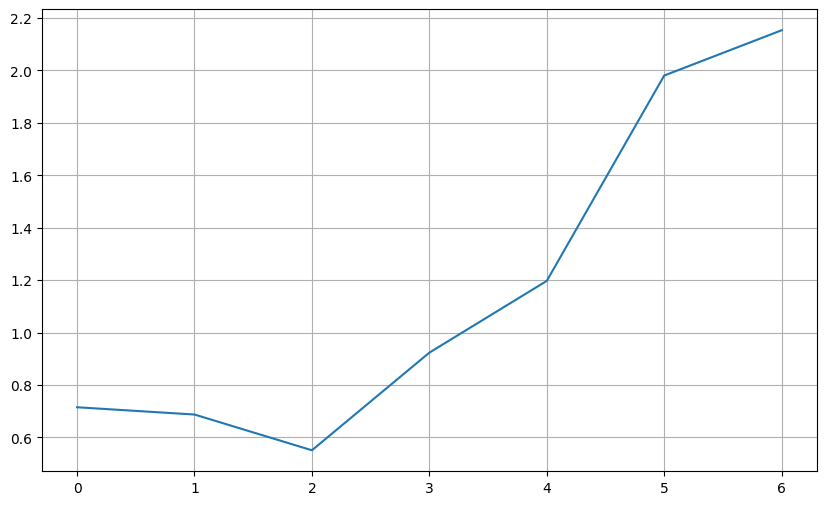

In [11]:
# Calculate information gain for each step in paths as proposed by the article(Probably not working properly)
inf_gain_list = []
batch_precision = 7
for _ in range(batch_precision):
    inf_gain_list.append([])

for path in processed_paths[0:1600]:
    for i in range(len(path) - 1):
        A = path[i]
        A_prime = path[i + 1]
        G = path[-1]

        # Calculate probabilities
        p_star = P_star(A_prime, A, G)
        H0 = -math.log2(1 / L_a[A]) if L_a[A] > 0 else 0
        H_star = -sum(
            [
                P_star(A_next, A, G) * math.log2(P_star(A_next, A, G))
                for A_next in outlinks[A]
            ]
        )

        # Calculate information gain
        information_gain = H0 - H_star

        normalised_distance_to_goal = i / (len(path) - 1)
        index = math.floor(normalised_distance_to_goal * batch_precision)
        inf_gain_list[index].append(information_gain)
        

import matplotlib.pyplot as plt

avg_inf_gain = []
for i, l in enumerate(inf_gain_list):
    avg_inf_gain.append([])
    avg_inf_gain[i] = sum(l) / len(l)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_inf_gain)
plt.grid(True)
plt.show()

We can see that the average information gain is dropping up to 3/7th of the path before rising.
This clearly distinguishes between the two phases, therefore the cut should be performed at 3/7 of the normalised path distance.

we recompute the distance by ignoring the 'get away to hub' stage

In [12]:
cut = 3/7

dp_cut = defaultdict(list)
for path in processed_paths:
    goal = path[-1]
    cut_index = int(len(path) * cut)
    for i in range(cut_index, len(path) - 1):
        dp_cut[(path[i], goal)].append(
            sum(
                [
                    math.log2(P_star(path[j + 1], path[j], goal))
                    for j in range(i, len(path) - 1)
                ]
            )
            / math.log2(pageranks[goal])
        )

d = {key: sum(value) / len(value) for key, value in dp_cut.items()}

## Evaluation of the distance

Quoting the original paper :

> An important property of our proposed distance measure is that it is not symmetric:
> in general, d(a, b) != d(b, a) (hence, it is not a distance in the strict geometric sense). 
> Although it could be easily symmetrized (e.g. by taking min{d(a, b), d(b, a)}), we do not do this,
> because asymmetry can be a desirable feature for psychological as well as philosophical reasons [Tversky, 1977].
> For instance, d(MINNEAPOLIS, MINNESOTA) = 0.22, while d(MINNESOTA, MINNEAPOLIS) = 0.12. 
> Intuitively, this makes sense: when one thinks of MINNEAPOLIS , MINNESOTA is probably one of the first associations,
> because MINNEAPOLIS is in MINNESOTA. On the flip side, there are many other places in M INNESOTA one could think of, 
> e.g. S T. PAUL , so when thinking of MINNESOTA , MINNEAPOLIS is not as predominant an association.
> We note that this asymmetry could perhaps be exploited to label concept relationships with their type (e.g. ‘is-part-of’).
> However, we donot address this issue here.

We are going to leverage this idea to extract a hierarchical structure out of the articles. Creating a tree of 'is-part-of' relationships.

For every pair of articles a,b if both d(a,b) and d(b,a) exist, we add a and b to a set of nodes and create a directed edge between a and b.
the edges represent the 'is part of' relationship, therefore if d(a,b) > d(b,a) the edge will be oriented from a towards b, reversed otherwise.
The edge will be assigned a weight that corresponds to how relevant the relationship is : we want to reward high assymetries = maximise d(a,b) - d(b,a), and reward relatedness = minimise d(a,b).
The motivation behind this is that similar topics like cat,dog will have small distances between each other but low assymmetry. On the other hand highly unrelated topics like cat,declaration_of_independence are likely to have assymetric distances but are unrelated. Interesting 'is-part-of' relationships like cat,animal will be both highly assymetric and closely related. We therefore choose the edge weight :

weight_edge_a_to_b = (d(a,b) - d(b,a))/(1 + d(a,b))

From this, we will obtain a directed graph. 
To convert this graph into a tree, we need to remove a certain number of edges. For each edge we remove, we need to pay the cost of the edge's weight, but we break some cycles. The problem consists in breaking all cycles at the minimal cost. This is exctly the problem of minimum spanning tree, that can be solved with Edmonds' algorithm for minimum spanning arborescence.

In [13]:
import math
import networkx as nx

def create_initial_graph(d):
    G = nx.DiGraph()
    for (a, b), dist_ab in d.items():
        if (b, a) in d:
            dist_ba = d[(b, a)]
            weight = (dist_ab - dist_ba) / (1 + dist_ab)
            if dist_ab > dist_ba:
                G.add_edge(a, b, weight=weight)
            else:
                G.add_edge(b, a, weight=-weight)
    return G


Never mind this is garbage, ask Nas for beautiful stuff if you are not convinced.

Let's plot the emotional jumps.

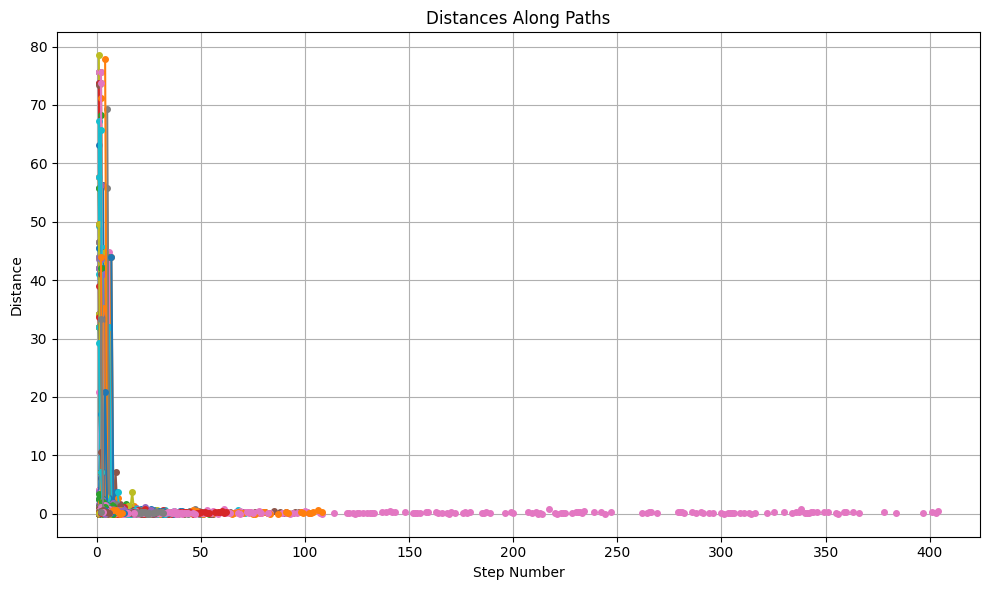

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

all_distances = []
max_length = 0 

for path in processed_paths:
    distances = [d.get((path[i-1], path[i]), None) for i in range(1, len(path))]
    max_length = max(max_length, len(distances))

for path in processed_paths:
    distances = [d.get((path[i-1], path[i]), None) for i in range(1, len(path))]
    distances += [None] * (max_length - len(distances))
    all_distances.append(distances)
    steps = range(1, len(distances) + 1)
    plt.plot(steps, distances, marker='o', linestyle='-', markersize=4)

plt.title('Distances Along Paths')
plt.xlabel('Step Number')
plt.ylabel('Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

df = pd.DataFrame(all_distances, columns=[f'Step_{i+1}' for i in range(max_length)])
df.to_csv('path_distances.csv', index=False)
# note for Haotian : when using this use the nan values as a mask
